In [13]:
# Import packagaes

# Basic packages
import numpy as np
import copy
import pandas as pd

# For plotting
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval

# To process fits file
from astropy.nddata import CCDData
from astropy.io import fits

# For numerical calculation
from astropy.stats import sigma_clipped_stats
from astropy.modeling import models, fitting

# For aperture photometry
from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture, CircularAnnulus, ApertureStats

# for matching
from astropy.wcs import WCS
from astropy.coordinates import match_coordinates_sky

# for query and standardization
from sklearn.linear_model import LinearRegression
from astroquery.sdss import SDSS
from astropy import coordinates as coords

In [14]:
# Setting matplotlib parameters
# You don't need to change this cell unless you want to change plotting styles.

plt.rcParams["font.family"] = 'STIXGeneral'
plt.rcParams['text.usetex'] = False
plt.rcParams["mathtext.fontset"] = 'cm'
# plt.rcParams['figure.figsize']=[4,3.5]
plt.rcParams['font.size']=20
plt.rcParams['axes.linewidth']=1
plt.rcParams['xtick.direction']='in'
plt.rcParams['ytick.direction']='in'
plt.rcParams['xtick.minor.visible']=True
plt.rcParams['ytick.minor.visible']=True
plt.rcParams['xtick.major.size']=7
plt.rcParams['ytick.major.size']=7
plt.rcParams['xtick.minor.size']=3.5
plt.rcParams['ytick.minor.size']=3.5
plt.rcParams['xtick.major.width']=1
plt.rcParams['ytick.major.width']=1
plt.rcParams['xtick.minor.width']=1
plt.rcParams['ytick.minor.width']=1
plt.rcParams['ytick.right']=True
plt.rcParams['xtick.top']=True

# 1. Import images

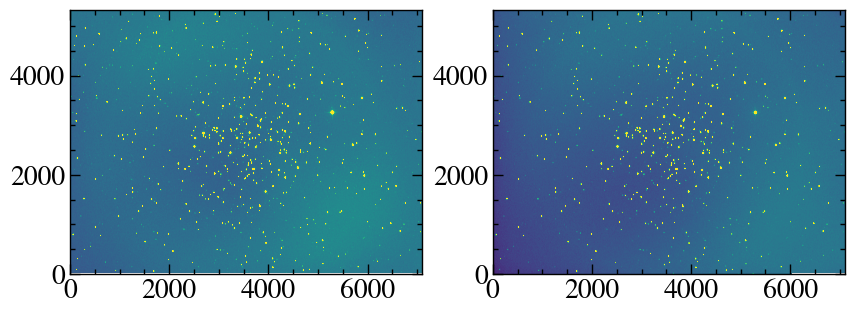

In [15]:
# Read fits data
rimage = CCDData.read('../data/M67_r.fits', hdu=0)
gimage = CCDData.read('../data/M67_g.fits', hdu=0)
# Save fits data in the list
data = [rimage, gimage]

# Plot the orginal image
# You may not need to change below
fig, ax = plt.subplots(1, 2, figsize=(5*2, 5))
for i, dat in enumerate(data):
    scaler = ZScaleInterval()
    vmin, vmax = scaler.get_limits(dat)
    ax[i].imshow(dat, vmin=vmin, vmax=vmax, origin='lower')

# 2. Detecting and centroiding stars


 id     xcentroid      ...        flux                mag         
--- ------------------ ... ------------------ --------------------
  1 3629.8654566973482 ...  7.244848732493722  -2.1500733053222993
  2  4358.222976820089 ... 1.2067957643111027  -0.2040844429777462
  3  3575.504479234103 ...   1.43210607827767 -0.38993797004200714
...                ... ...                ...                  ...
870 3737.8787320352503 ... 1.6967051020390116  -0.5740159144470434
871  4991.307611398365 ... 15.741136881449195  -2.9925902386582575
872   4317.26138554491 ...  2.111960233783185  -0.8117143414594565
Length = 872 rows



 id     xcentroid      ...        flux                mag         
--- ------------------ ... ------------------ --------------------
  1 3630.2146697262506 ... 1.8175395521641817  -0.6487096762001087
  2 1687.4716259169013 ... 16.530593748694756  -3.0457211322877766
  3   922.013258573583 ...  4.237296677433926   -1.567722181280355
...                ... ...                ...                  ...
620  5079.936659486021 ... 1.3863098874301005 -0.35465080180402614
621  6991.798963758281 ... 2.4806570603131726  -0.9864168229053687
622    4991.5335943171 ...  4.580229239428233  -1.6522180372188768
Length = 622 rows


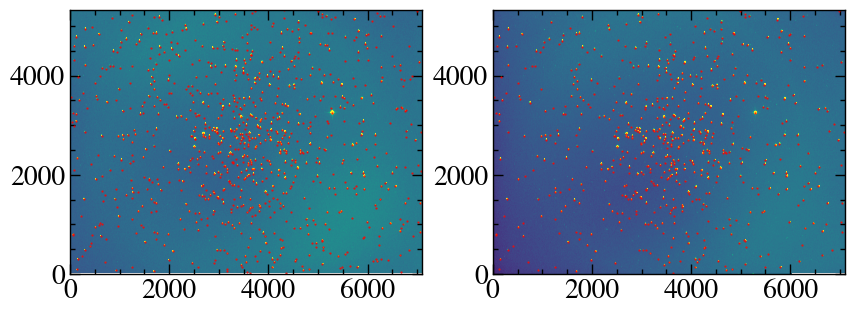

In [16]:
pos = [] # list to save the positions of detected stars in each image

# parameter settings
thres = 10 # pixel value above which, when multiplied by sigma, pixels are considered to be stars.
fwhm = 10 # minimum radius over which objects are considered to be stars.

for dat in data:
    avg, med, std = sigma_clipped_stats(dat.data) # taking the statistics of the image with sigma clipping. Default clipping threshold is 3*sigma
    finder = DAOStarFinder(threshold=thres*std, fwhm=fwhm, exclude_border=True) # set a finder to detect a star
    sources = finder(dat.data - med) # detect stars. median is subtracted to minize the cotamination by the background
    print()
    sources.pprint(max_lines=10)
    pos.append(np.transpose((sources['xcentroid'], sources['ycentroid']))) # save the position of the stars

# Plot the detected stars
# You may not need to change it.
fig, ax = plt.subplots(1, 2, figsize=(5*2, 5))
for i, dat in enumerate(data):
    scaler = ZScaleInterval()
    vmin, vmax = scaler.get_limits(dat)
    ax[i].imshow(dat, vmin=vmin, vmax=vmax, origin='lower')
    ax[i].plot(pos[i][:,0], pos[i][:,1], 'ro', markersize=0.5)

# 3. Sum pixel values within the area of the stars

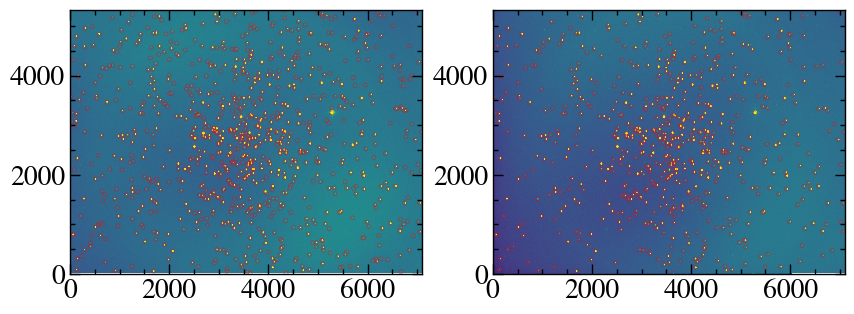

In [17]:
# Set apertures
apertures = [CircularAperture(pos[0], r=4*fwhm), CircularAperture(pos[1], r=4*fwhm)] # Here, we define the aperture with the radius of 4 times FWHM
sum_stars = [] # list to save the sum of pixel values of each star

for dat, aper in zip(data, apertures):
    starphot = ApertureStats(dat, aper) # take statistics of the pixel values within the area of the stars
    sum_stars.append(starphot.sum) # sum of the pixel values within the area of the stars
    
# Plot the detected stars
# You may not need to change it.
fig, ax = plt.subplots(1, 2, figsize=(5*2, 5))
for i, (dat, aper) in enumerate(zip(data, apertures)):
    scaler = ZScaleInterval()
    vmin, vmax = scaler.get_limits(dat)
    ax[i].imshow(dat, vmin=vmin, vmax=vmax, origin='lower')
    aper.plot(ax[i], color='r', alpha=0.5 ,lw=0.5)

# 4. sky annulus

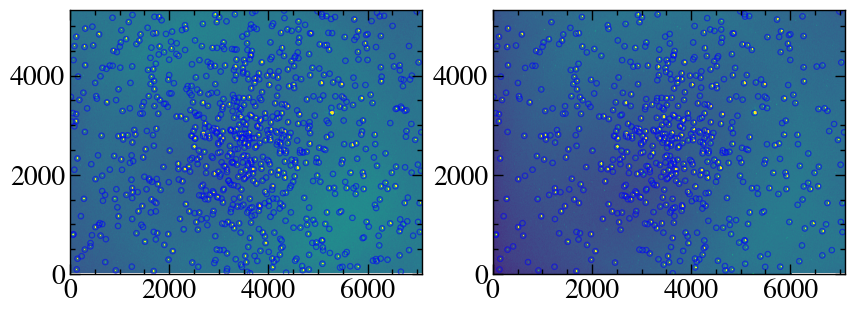

In [18]:
# Set annulus
annuluses = [CircularAnnulus(pos[0], r_in=fwhm*5, r_out=fwhm*6), CircularAnnulus(pos[1], r_in=fwhm*5, r_out=fwhm*6)] # Here, we define the aperture with the inner radius of 5 times FWHM and the outer radius of 6 times FWHM
mode_bkg = [] # list to save the mode of the background for each annulus

for dat, annul in zip(data, annuluses):
    bkgphot = ApertureStats(dat, annul) # take statistics of the pixel values within the annuluses
    mode_bkg.append(2.5*bkgphot.median-1.5*bkgphot.mean) # sum of the pixel values within the annuluses
    
# Plot the detected stars
# You may not need to change it.
fig, ax = plt.subplots(1, 2, figsize=(5*2, 5))
for i, (dat, annul) in enumerate(zip(data, annuluses)):
    scaler = ZScaleInterval()
    vmin, vmax = scaler.get_limits(dat)
    ax[i].imshow(dat, vmin=vmin, vmax=vmax, origin='lower')
    annul.plot(ax[i], color='b', alpha=0.5 ,lw=0.5)

# 5. Aperture photometry

In [19]:
mags = [] # list to save the magnitudes of each star
for dat, sum, bkg, aper in zip(data, sum_stars, mode_bkg, apertures):
    flux = sum-aper.area_overlap(dat)*bkg # star - background
    mag = 22.5-2.5*np.log10(flux.value) # transfrom flux to magnitude
    mags.append(mag)

/var/folders/tz/3b0hb0qd35gfvjpy9c1vqqfm0000gn/T/ipykernel_65967/2477943320.py:4: RuntimeWarning: invalid value encountered in log10
  mag = 22.5-2.5*np.log10(flux.value) # transfrom flux to magnitude


# 7. Matching

In [20]:
# You may not need to revise this

# convert pixel coordinates to ra, dec
coord = [WCS(fits.open('../data/M67_r.fits')[0].header).pixel_to_world(pos[0][:,0], pos[0][:,1]),
        WCS(fits.open('../data/M67_g.fits')[0].header).pixel_to_world(pos[1][:,0], pos[1][:,1])]
# matching
match_idx, match_angle,_ = match_coordinates_sky(coord[0], coord[1])

# construct a table with the columns of x_r, y_r, x_g, y_g, mag_r, mag_g
# In the table, only stars with mathcing_angle<1.5 arcsec (~seeing of SDSS)
rlim = 1.5
table=np.vstack([pos[0][:,0], pos[0][:,1], pos[1][match_idx,0], pos[1][match_idx,1],
                 coord[0].ra.value, coord[0].dec.value, coord[1].ra.value[match_idx], coord[1].dec.value[match_idx],
                 mags[0], mags[1][match_idx]]).T
table = table[match_angle.to_value('arcsec')<1.5,:]
table = pd.DataFrame(table, columns=['x_r', 'y_r', 'x_g', 'y_g', 'ra_r', 'dec_r', 'ra_g', 'dec_g', 'mag_r_inst', 'mag_g_inst'])
table = table.dropna().reset_index(drop=True) # removing rows with NaN values

Text(0, 0.5, '$\\Delta\\mathrm{Dec.}$')

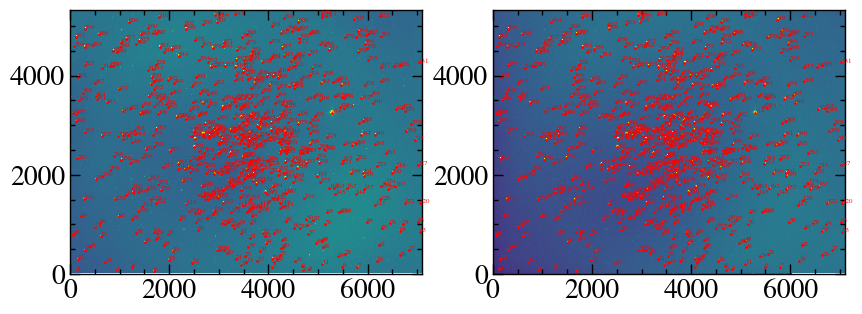

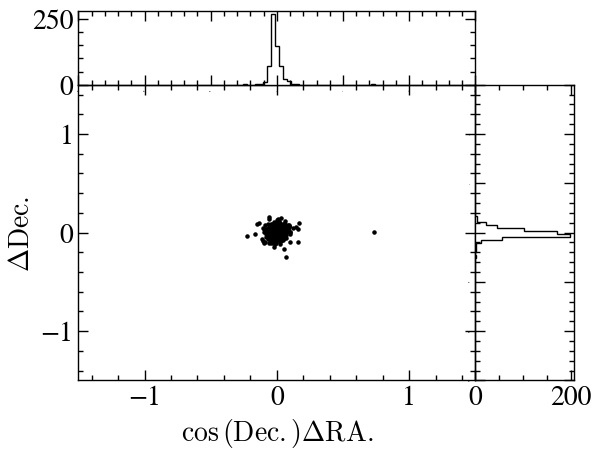

In [21]:
# Check if the mathching is done correctly
# If the matching is correct, the scatters center at (0,0)
# You may not need to revise it.

fig, ax = plt.subplots(1, 2, figsize=(5*2, 5))
for i, (dat, annul) in enumerate(zip(data, annuluses)):
    scaler = ZScaleInterval()
    vmin, vmax = scaler.get_limits(dat)
    ax[i].imshow(dat, vmin=vmin, vmax=vmax, origin='lower')
ax[0].scatter(table['x_r'], table['y_r'], color='r', s=1)
for i in np.arange(len(table['x_r'])):
    ax[0].text(table['x_r'][i], table['y_r'][i], f'{i:d}', color='r', fontsize=5)
ax[1].scatter(table['x_g'], table['y_g'], color='r', s=1)
for i in np.arange(len(table['x_g'])):
    ax[1].text(table['x_g'][i], table['y_g'][i], f'{i:d}', color='r', fontsize=5)

fig = plt.figure()
fig.subplots_adjust(wspace=0, hspace=0)
gs = fig.add_gridspec(5,5)
point = fig.add_subplot(gs[1:,:4])
x_hist = fig.add_subplot(gs[0,:4])
x_hist.tick_params(axis='x', labelsize=0)
y_hist = fig.add_subplot(gs[1:,4])
y_hist.tick_params(axis='y', labelsize=0)

dra, ddec = (table['ra_r']-table['ra_g'])*3600*np.cos(np.median(table['dec_r']*np.pi/180)), (table['dec_r']-table['dec_g'])*3600 # difference of ra and dec in degree.
bins = np.linspace(-rlim,rlim,100)
point.scatter(dra, ddec, marker='o', color='k', s=5)
point.set_xlim(bins[0], bins[-1])
point.set_ylim(bins[0], bins[-1])

x_hist.hist(dra, bins=bins, color='k', histtype='step')
x_hist.set_xlim(bins[0], bins[-1])
y_hist.hist(ddec, bins=bins, color='k', histtype='step', orientation='horizontal')
y_hist.set_ylim(bins[0], bins[-1])

point.set_xlabel(r'$\cos{(\mathrm{Dec.})}\Delta\mathrm{RA.}$')
point.set_ylabel(r'$\Delta\mathrm{Dec.}$')

# 8. Standardization

In [38]:
from astroquery.mast import Catalogs
from astroquery.vizier import Vizier
from astropy.coordinates import SkyCoord
import numpy as np
import astropy.units as u
from astropy.table import Table


# List to store query from Pan-STARRS and APASS
apass_query = []

bright40 = np.argsort(table['mag_r_inst'])[100:140]
matched_mag_r, matched_mag_g = [], []
# Loop over RA and Dec coordinates to query SDSS
for ra, dec, mag_r, mag_g in zip(table['ra_r'][bright40], table['dec_r'][bright40], table['mag_r_inst'][bright40], table['mag_g_inst'][bright40]):
    # Create a SkyCoord object for each RA, Dec pair
    co = SkyCoord(ra, dec, unit='deg', frame='icrs')
    
    
    # Query APASS using Vizier with a small radius of 1 arcsecond
    try:
        vizier = Vizier(row_limit=-1)
        match = vizier.query_region(co, radius=1 * u.arcsec, catalog='II/336/apass9')

        # Apply non-saturation conditions for APASS
        if len(match) > 0:
            apass_data = match[0]
            apass_filtered = apass_data[
                (apass_data['r_mag'] > 10) &  # Avoid saturated stars in r band (for APASS)
                (apass_data['g_mag'] > 10)    # Avoid saturated stars in g band (for APASS)
            ]
            if len(apass_filtered) > 0:
                apass_query.append(apass_filtered[0])  # Closest APASS result
                matched_mag_r.append(mag_r)
                matched_mag_g.append(mag_g)
        else:
            print(f"No APASS results for RA={ra}, Dec={dec}")

    except Exception as e:
        print(f"Error querying APASS for RA={ra}, Dec={dec}: {e}")

# Combine APASS results into one table (if results exist)
if apass_query:
    apass_query = pd.DataFrame(apass_query, columns = apass_data.keys())
    apass_query['mag_r_inst'] = matched_mag_r
    apass_query['mag_g_inst'] = matched_mag_g
    print("APASS Results:")
    print(apass_query)
else:
    print("No APASS results found for the given RA and Dec coordinates.")

No APASS results for RA=132.86995070437982, Dec=11.86659582921439


No APASS results for RA=132.95466242623854, Dec=11.828753999904349


No APASS results for RA=132.85030835214948, Dec=11.806076577786802


No APASS results for RA=132.74898983422491, Dec=11.656178095574525


No APASS results for RA=132.84693923786443, Dec=11.80735582133419


No APASS results for RA=132.88305260889769, Dec=11.886515849785063


No APASS results for RA=132.8860890511611, Dec=11.841881593585448


No APASS results for RA=132.87991817570403, Dec=11.888248795337335


No APASS results for RA=132.8678634785967, Dec=11.871464040075484
APASS Results:
      recno     RAJ2000    DEJ2000  e_RAJ2000  e_DEJ2000     Field  nobs  \
0   5188630  132.643253  11.665743      0.164      0.155  20120587     5   
1   5188639  132.650525  11.721679      0.076      0.070  20150586     4   
2   5188750  132.905699  11.834695      0.339      0.126  20120587     5   
3   5188550  133.089103  11.844968      0.201      0.126  20120587     5   
4   5189061  132.918426  12.030623      0.193      0.215  20120587     5   
5   5188698  132.880152  11.764066      0.252      0.190  20120587     5   
6   5188755  132.883867  11.834288      0.336      0.213  20120587     5   
7   5188702  132.900011  11.776014      0.182      0.309  20120587     5   
8   5188661  132.763539  11.763149      0.128      0.175  20120587     5   
9   5188687  132.754383  11.836366      0.115      0.320  20120587     5   
10  5189213  132.750727  11.908952      0.294      0.405  20120587     5   
11  518

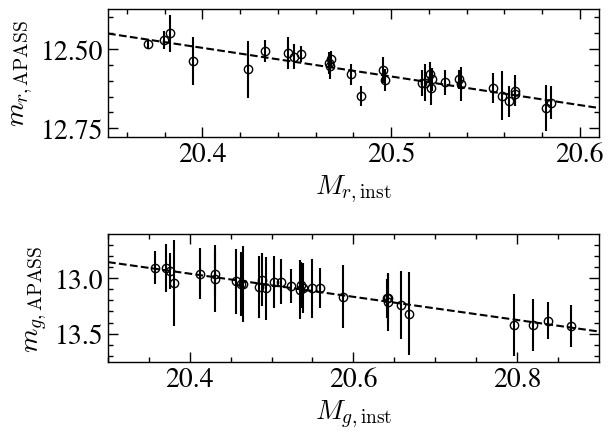

In [49]:
stad_r = LinearRegression()
stad_r.fit(X=apass_query['mag_r_inst'].to_numpy().reshape(-1, 1) , y=apass_query['r_mag'])
stad_g = LinearRegression()
stad_g.fit(X=apass_query['mag_g_inst'].to_numpy().reshape(-1, 1) , y=apass_query['g_mag'])

r_range = np.array([20.35,20.61])
g_range = np.array([20.3,20.9])

fig, ax = plt.subplots(2,1)
ax[0].errorbar(apass_query['mag_r_inst'], apass_query['r_mag'], yerr=apass_query['e_r_mag'], fmt='ko', markerfacecolor='none')
ax[0].plot(r_range, stad_r.predict(r_range.reshape(-1, 1)), 'k--')
ax[0].set_ylim(ax[0].get_ylim()[::-1])
ax[0].set_xlabel(r'$M_{r, {\rm inst}}$')
ax[0].set_ylabel(r'$m_{r, {\rm APASS}}$')
ax[0].set_xlim(r_range)

ax[1].errorbar(apass_query['mag_g_inst'], apass_query['g_mag'], yerr=apass_query['e_g_mag'], fmt='ko', markerfacecolor='none')
ax[1].plot(g_range, stad_g.predict(g_range.reshape(-1, 1)), 'k--')
ax[1].set_ylim(ax[1].get_ylim()[::-1])
ax[1].set_xlabel(r'$M_{g, {\rm inst}}$')
ax[1].set_ylabel(r'$m_{g, {\rm APASS}}$')
ax[1].set_xlim(g_range)

fig.tight_layout()

table['mag_r'] = stad_r.predict(table['mag_r_inst'].to_numpy().reshape(-1,1))
table['mag_g'] = stad_g.predict(table['mag_g_inst'].to_numpy().reshape(-1,1))

# 8. CMD

Text(0, 0.5, 'r')

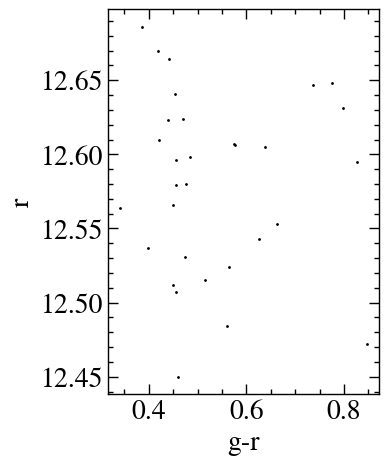

In [50]:
fig, ax = plt.subplots(1,1, figsize=(3.5,5))

ax.scatter(apass_query['g_mag']-apass_query['r_mag'], apass_query['r_mag'], s=1, color='k')
ax.set_xlabel('g-r')
ax.set_ylabel('r')
# ax.set_xlim(-2,5)
# ax.set_ylim(14,12)

(18.0, 8.0)

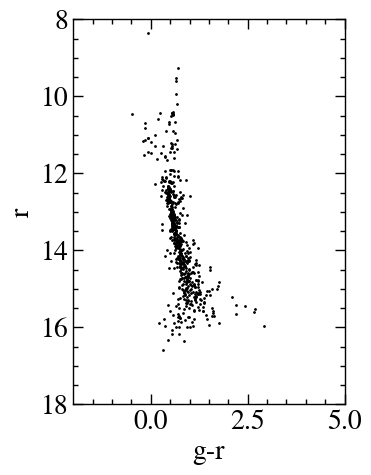

In [51]:
# plot CMD
# If you've run the above cells successfully, you don't need to revsie this (except for x, y ranges)
fig, ax = plt.subplots(1,1, figsize=(3.5,5))

ax.scatter(table['mag_g']-table['mag_r'], table['mag_r'], s=1, color='k')
ax.set_xlabel('g-r')
ax.set_ylabel('r')
ax.set_xlim(-2,5)
ax.set_ylim(18,8)